In [1]:
from matplotlib.lines import lineStyles
from scipy import special as sp
import numpy as np

from matplotlib import pyplot as plt

# Introduction

The purpose of this code is to prototype the calculation of the leaf water potential, $\psi_l$, for the whole trunk impairment model, before adding it to the JULES code.

The transpiration rate for the model is given by:

$$
E(\psi_l) = \frac{\psi_l - \psi_r}{\psi_{l \text{extreme}} - \psi_{r \text{extreme}}} \int_{\psi_{r \text{extreme}}}^{\psi_{l \text{extreme}}} k(\psi) d\psi
$$

Where $\psi_l$ is the leaf water potential we want to calculate, $k(\psi)$ is the trees vulnerability curve, $\psi_r$ is the root water potential, and $\psi_{l \text{extreme}}$ and $\psi_{r \text{extreme}}$ are the minimum values of the leaf and root water potentials upto and including the current point in time, respectively. Note $\psi_l$ is the leaf water potential at the current point in time.

$$
\psi_{l \text{extreme}} = \min(\psi_l(t), t \leq t_{current})
$$

$$
\psi_{r \text{extreme}} = \min(\psi_r(t), t \leq t_{current})
$$

Since the value of $\psi_l$ is not known, neither is the value of $\psi_{l \text{extreme}}$.

# Model setup

Inorder to test any solution to the problem of finding $\psi_l$ we need a set of test data with paired $\psi_l$ and $E(\psi_l)$. the esiest way to do this is to calculate $E(\psi_l)$ for a set of $\psi_l$. This needs to be done for the two vulnerability curves.

## Cumulative Weibull

The Cumulative Weibull vulnerability curve is given by;

$$
k(\psi) = \exp^{-\left(\frac{\psi}{b}\right)^c}
$$

In [2]:
def conductance_CW(psi, b, c):
    return np.exp(-((psi/b)**c))

The integral of the vulnerability curve between two points is then given by;

$$
E(\psi_l, \psi_r) = k_{max} \frac{b}{c} [\gamma(1/c,x)]_{x_r}^{x_l}
$$

Where $\gamma(a,x)$ is the lower incomplete gamma function and $x = (\psi/b)^c$.

To calculate the incomplete gamma function we first need the gamma function. The code bellow is taken from the Newton_Raphson_water_potential.ipynb file. See that file for tests and explanations.


In [3]:
def gamma(a):
    """
    Estimates the normalised gamma function evaluated at a.
    """

    # Coeficients taken from Numerical recipies for Fortran 90 volume 1 page 207
    coefficients = [ 76.18009172947146,
                    -86.50532032941677,
                     24.01409824083091,
                    - 1.231739572450155,
                      0.1208650973866179e-2,
                    - 0.5395239384953e-5]
    coefficients = np.asarray(coefficients)
    n_array = [float(i) for i in range(0,6)]
    n_array = np.asarray(n_array)

    gamma = np.power(a + 5.5, a + 0.5)
    gamma *= np.exp(-a-5.5) 
    gamma *= (2.5066282746310005/a)
    gamma *= (1.000000000190015 + np.sum(coefficients / (a + 1. + n_array)))

    return gamma

From the same file, the incomplete gamma function is given by;

In [4]:
def incomplete_gamma_series(a,x, N = 100, precision = 0.00001, verbose = False):
    """
    Estimates the incomplete gamma function using a series expansion.
    """

    denominator = a
    summ = 1./a
    step = summ

    if(verbose):
        print("denominator: ", denominator)
        print("step: ", step)
        print("sum: ", summ)

    for i in range(0,N):
        denominator += 1.
        step *= x/denominator
        summ += step

        if(verbose):
            print("\nitter: ", i)
            print("denominator: ", denominator)
            print("step: ", step)
            print("sum: ", summ)

        if(abs(step) < abs(summ) * precision):
            if(verbose):
                print("itterations = ", i)
            break
    if(verbose):
        print("\nScale: ", np.exp(-x) * np.power(x,a))
    
    return summ  * np.exp(-x) * np.power(x,a)

def norm_incomplete_gamma_series(a, x,  N = 100, precision = 0.00001, verbose = False):
    """
    Estimates the normalised incomplete gamma function.
    """
    return incomplete_gamma_series(a, x, N, precision, verbose) / gamma(a)

The unimpaired transpiration rate is then given by;

In [5]:
def transpiration_CW(psi_r, psi_l, k_max, b, c, N = 100, precision = 0.001):
    """
    Calcualtes the transpiration rate between two water potentials when the xylem conductance
    is modeld as a cuulative Weibull distribution.
    """

    # Convert the limits into the appropriate form
    x_l = np.power(psi_l/b,c)
    x_r = np.power(psi_r/b,c)


    # calculate the multiplyer infront of the integral
    multiplyer = k_max * b/c
    
    return multiplyer * (incomplete_gamma_series(1/c,x_r, N, precision) - incomplete_gamma_series(1/c,x_l, N, precision))


The impaired transpiration rate is then given by;

In [6]:
def impaired_transpiration_CW(psi_r, psi_l, psi_r_extreme, psi_l_extreme, k_max, b, c, N = 100, precision = 0.001):
    """
    Calculates the impaired transpiration rate between two water potentials when the xylem conductance
    """
    
    # If the leaf (root) water potential is less than the extreme leaf (root) water potential we update the extreme leaf (root) water potential
    psi_r_extreme = np.clip(psi_r, a_min=None, a_max=psi_r_extreme)
    psi_l_extreme = np.clip(psi_l, a_min=None, a_max=psi_l_extreme)
    
    # Calculate the transpiration between the extreme leaf and root water potentials
    E_extreme = transpiration_CW(psi_r_extreme, psi_l_extreme, k_max, b, c, N, precision)
    
    # Scale the transpiration rate by the ratio of the extreme leaf and root water potentials
    return E_extreme * (psi_l - psi_r) / (psi_l_extreme - psi_r_extreme), psi_l_extreme, psi_r_extreme

### Visualisation

Let's quickly plot the transpiration as a function of leaf water potential to se it's shape.

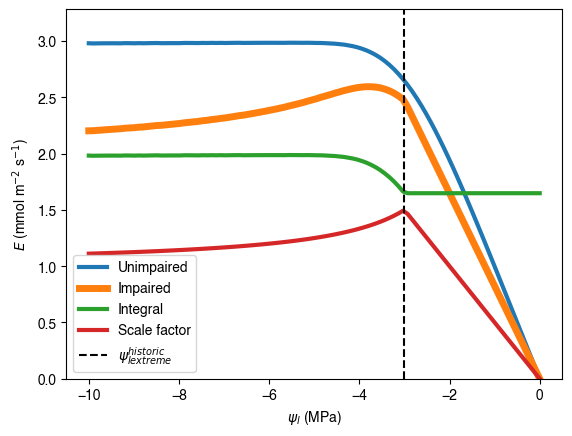

In [7]:
k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

psi_r = -0.0 # MPa
psi_l = np.linspace(psi_r, -10.0, 100) # MPa
psi_r_extreme = -1.0 # MPa
psi_l_extreme = -3.0 # MPa

E = np.zeros(len(psi_l))
E_impaired = np.zeros(len(psi_l))
Integral = np.zeros(len(psi_l))
psi_l_extreme_new = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    E[i] = transpiration_CW(psi_r, psi_l[i], k_max, b, c)
    E_impaired[i], psi_l_extreme_new[i], __ = impaired_transpiration_CW(psi_r, psi_l[i], psi_r_extreme, psi_l_extreme, k_max, b, c)
    Integral[i] = transpiration_CW(psi_r_extreme, psi_l_extreme_new[i], k_max, b, c)

# scaling factor applied to 
scale_factor = (psi_l - psi_r) / (psi_l_extreme_new - psi_r_extreme)

# -- Plotting --
plt.plot(psi_l, E, label = 'Unimpaired', linewidth = 3)
plt.plot(psi_l, E_impaired, label = 'Impaired', linewidth = 5)
plt.plot(psi_l, Integral, label = 'Integral', linewidth = 3)
plt.plot(psi_l, scale_factor, label = 'Scale factor', linewidth = 3)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.ylim(0, 1.1*max(E))
plt.legend()
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$E$ (mmol m$^{-2}$ s$^{-1}$)")
plt.show()

In the plot above the blue and orange lines are the transpiration for an unimpaired and impaired trunk respectively. For descriptive purposes the impaired transpiration has also been split into the integral ($\int_{\psi_{r\text{extreme}}}^{\psi_{l \text{extreme}}}k(\psi) d\psi$) and scaling ($\frac{\psi_l - \psi_r}{\psi_{l\text{extreme}} - \psi_{r\text{extreme}}}$) components, the green and red lines respectively. The vertical dashed line indicates the point at which the new leaf water potential is equal to the historic minimum.

The figure can be split into two regions. On the right hand side of the dashed vertical line the leaf water potential is greater than the historic minimum. Here the only thing changing is the leaf water potential. This means that the integral component is constant and the scaling factor in front of it changes linearly, resulting in a linear relation between the leaf water potential and the transpiration rate.

On the left hand side of the vertical line the leaf water potential is less than the historic minimum, hence the new extreme water potential is now equal to the leaf water potential. The integral component is now a function of the leaf water potential, increasing as the leaf water potential becomes more negative, the range of the integration increases. Within the scaling factor both the numerator and the denominator are now linearly related to the leaf water potential, resulting in the fraction reducing towards one as the leaf water potential becomes more negative. The result is a transpiration rate that peaks at a some maximum value before reducing as the leaf water potential becomes more negative. The cause of this somewhat unintuitive result is that the root water potential is greater than the historic minimum root water potential. If we set the historic minimum root water potential to be equal to the root water potential the scaling factor is equal to one when the leaf water potential is the new minimum (to the left of the dashed line). This can be seen in the plot below.



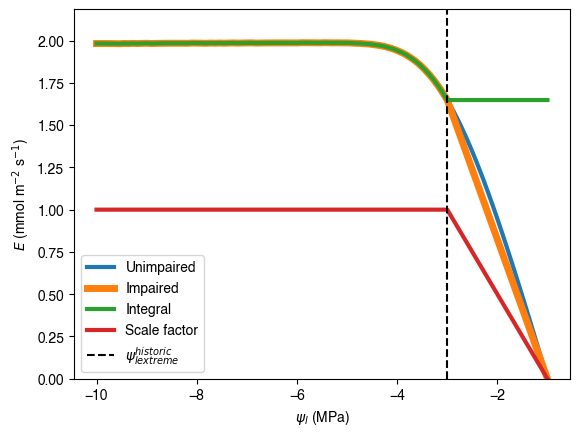

In [8]:
psi_r = -1.0 # MPa
psi_l = np.linspace(psi_r, -10.0, 100) # MPa
psi_r_extreme = -1.0 # MPa
psi_l_extreme = -3.0 # MPa

E = np.zeros(len(psi_l))
E_impaired = np.zeros(len(psi_l))
Integral = np.zeros(len(psi_l))
psi_l_extreme_new = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    E[i] = transpiration_CW(psi_r, psi_l[i], k_max, b, c)
    E_impaired[i], psi_l_extreme_new[i], __ = impaired_transpiration_CW(psi_r, psi_l[i], psi_r_extreme, psi_l_extreme, k_max, b, c)
    Integral[i] = transpiration_CW(psi_r_extreme, psi_l_extreme_new[i], k_max, b, c)

# scaling factor applied to 
scale_factor = (psi_l - psi_r) / (psi_l_extreme_new - psi_r_extreme)

# -- Plotting --
plt.plot(psi_l, E, label = 'Unimpaired', linewidth = 3)
plt.plot(psi_l, E_impaired, label = 'Impaired', linewidth = 5)
plt.plot(psi_l, Integral, label = 'Integral', linewidth = 3)
plt.plot(psi_l, scale_factor, label = 'Scale factor', linewidth = 3)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.ylim(0, 1.1*max(E))
plt.legend()
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$E$ (mmol m$^{-2}$ s$^{-1}$)")
plt.show()

## SOX

The SOX vulnerability curve is given by;

$$
k(\psi) = \frac{1}{1 + \frac{\psi}{b}^{c}}
$$

In [9]:
def conductance_SOX(psi, b, c):
    return 1/(1 + (psi/b)**c)

The integral of the vulnerability curve between two points is then given by;

$$ 
E(\psi_l, \psi_r) = k_{max} [\psi \;\; _2F_1(1,\frac{1}{c};1+\frac{1}{c};-(\frac{\psi}{b})^c)]_{\psi_r}^{\psi_l}
$$

Where $_2F_1()$ is the hypergeometric series.

To calculate the integral w need a function to calculate the hypergeometric series. The code bellow is taken from the Newton_Raphson_water_potential.ipynb file. See that file for tests and explanations.

In [10]:
def HGS_2F1_mod_of_x_lessthan_1(a_f, b_f, c_f, x, itters = 100, precision = 0.01, verbose = False):

    """
    Calculate the hypergeometric series upto n = itters or the step change is less than prescision.
    """
    
    if(np.abs(x) >= 1.):
        print("error: |" + str(x) + "| >= 1")
        return 0
    
    F_out = 1
    step = F_out

    for i in range(itters):

        if(verbose):
            print("\nIter = ", i)
            print("step = ", step)
            print("F_out = ", F_out)
        
        step *= ((a_f+i)*(b_f+i)/(c_f+i)) * (x/(i+1))
        F_out += step

        if(np.abs(step) < precision):
            break

    return F_out

def HGS_2F1_x_lessthan_or_equal_0(a_f, b_f, c_f, x, itters = 100, precision = 0.01, verbose = False):

    """
    Calculate the hypergeometric series when x is less than 0.
    """
    
    if(x > 0.):
        print("error: " + str(x) + " > 0")
        return 0
    
    return np.power(1-x, -a_f) * HGS_2F1_mod_of_x_lessthan_1(a_f, c_f - b_f, c_f, x / (x - 1), itters, precision, verbose) 


Now we can calculate the transpiration rate for the SOX vulnerability curve.

In [11]:
def transpiration_SOX(psi_r, psi_l, k_max, b, c, N = 1000, precision = 0.001, verbose = False):
    """
    Calcualtes the transpiration rate between two water potentials when the xylem conductance
    is modeld as in SOX 2018.
    """

    a_2f1 = 1.
    b_2f1 = 1/c
    c_2f1 = 1 + 1/c
    x_l = -(psi_l/b)**c
    x_r = -(psi_r/b)**c

    if(verbose):
        print("\n-- transpiration SOX --")
        print("a_2f1 = ", a_2f1)
        print("b_2f1 = ", b_2f1)
        print("c_2f1 = ", c_2f1)
        print("x_2f1_l = ", x_l)
        print("x_2f1_r = ", x_r)
        print("HGS_2F1(x_l) = ", HGS_2F1_x_lessthan_or_equal_0(a_2f1, b_2f1, c_2f1, x_l, N, precision))
        print("HGS_2F1(x_r) = ", HGS_2F1_x_lessthan_or_equal_0(a_2f1, b_2f1, c_2f1, x_r, N, precision))
    
    return k_max * (psi_r * HGS_2F1_x_lessthan_or_equal_0(a_2f1, b_2f1, c_2f1, x_r, N, precision) - psi_l * HGS_2F1_x_lessthan_or_equal_0(a_2f1, b_2f1, c_2f1, x_l, N, precision))

The impaired transpiration rate is then given by;

In [12]:
def impaired_transpiration_SOX(psi_r, psi_l, psi_r_extreme, psi_l_extreme, k_max, b, c, N = 1000, precision = 0.001):
    """
    Calculates the impaired transpiration rate between two water potentials when the xylem conductance
    """
    
    # If the leaf (root) water potential is less than the extreme leaf (root) water potential we update the extreme leaf (root) water potential
    psi_r_extreme = np.clip(psi_r, a_min=None, a_max=psi_r_extreme)
    psi_l_extreme = np.clip(psi_l, a_min=None, a_max=psi_l_extreme)
    
    # Calculate the transpiration between the extreme leaf and root water potentials
    E_extreme = transpiration_SOX(psi_r_extreme, psi_l_extreme, k_max, b, c, N, precision)
    
    # Scale the transpiration rate by the ratio of the extreme leaf and root water potentials
    return E_extreme * (psi_l - psi_r) / (psi_l_extreme - psi_r_extreme), psi_l_extreme, psi_r_extreme

### Visualisation

Lets again quickly visualise the transpiration rate but for the SOX vulnerability curve.

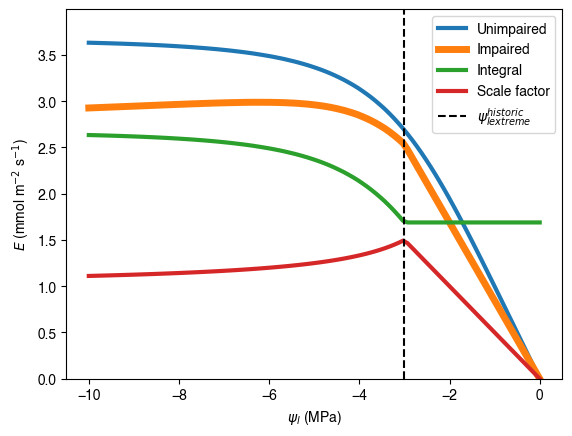

In [13]:
k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

psi_r = -0.0 # MPa
psi_l = np.linspace(psi_r, -10.0, 100) # MPa
psi_r_extreme = -1.0 # MPa
psi_l_extreme = -3.0 # MPa

E = np.zeros(len(psi_l))
E_impaired = np.zeros(len(psi_l))
Integral = np.zeros(len(psi_l))
psi_l_extreme_new = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    E[i] = transpiration_SOX(psi_r, psi_l[i], k_max, b, c)
    E_impaired[i], psi_l_extreme_new[i], __ = impaired_transpiration_SOX(psi_r, psi_l[i], psi_r_extreme, psi_l_extreme, k_max, b, c)
    Integral[i] = transpiration_SOX(psi_r_extreme, psi_l_extreme_new[i], k_max, b, c)

# scaling factor applied to 
scale_factor = (psi_l - psi_r) / (psi_l_extreme_new - psi_r_extreme)

# -- Plotting --
plt.plot(psi_l, E, label = 'Unimpaired', linewidth = 3)
plt.plot(psi_l, E_impaired, label = 'Impaired', linewidth = 5)
plt.plot(psi_l, Integral, label = 'Integral', linewidth = 3)
plt.plot(psi_l, scale_factor, label = 'Scale factor', linewidth = 3)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.ylim(0, 1.1*max(E))
plt.legend()
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$E$ (mmol m$^{-2}$ s$^{-1}$)")
plt.show()

Here we can see that the impaired transpiration takes the same general form as that for the Cumulative Weibull distribution. Further if we set the root water potential equal to the minimum root water potential the reduction in transpiration at more negative leaf water potentials is removed, see below.

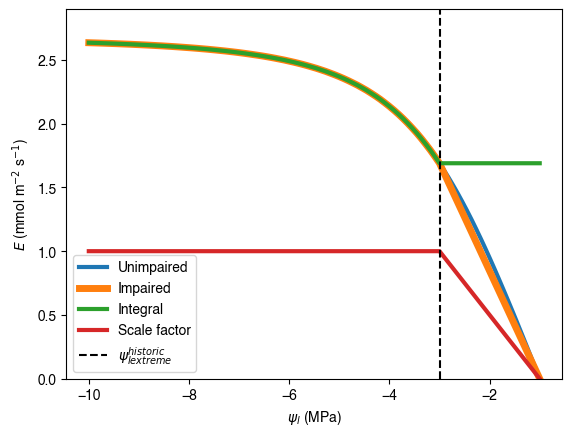

In [14]:
psi_r = -1.0 # MPa
psi_l = np.linspace(psi_r, -10.0, 100) # MPa
psi_r_extreme = -1.0 # MPa
psi_l_extreme = -3.0 # MPa

E = np.zeros(len(psi_l))
E_impaired = np.zeros(len(psi_l))
Integral = np.zeros(len(psi_l))
psi_l_extreme_new = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    E[i] = transpiration_SOX(psi_r, psi_l[i], k_max, b, c)
    E_impaired[i], psi_l_extreme_new[i], __ = impaired_transpiration_SOX(psi_r, psi_l[i], psi_r_extreme, psi_l_extreme, k_max, b, c)
    Integral[i] = transpiration_SOX(psi_r_extreme, psi_l_extreme_new[i], k_max, b, c)

# scaling factor applied to 
scale_factor = (psi_l - psi_r) / (psi_l_extreme_new - psi_r_extreme)

# -- Plotting --
plt.plot(psi_l, E, label = 'Unimpaired', linewidth = 3)
plt.plot(psi_l, E_impaired, label = 'Impaired', linewidth = 5)
plt.plot(psi_l, Integral, label = 'Integral', linewidth = 3)
plt.plot(psi_l, scale_factor, label = 'Scale factor', linewidth = 3)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.ylim(0, 1.1*max(E))
plt.legend()
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$E$ (mmol m$^{-2}$ s$^{-1}$)")
plt.show()

# Solving for the leaf water potential

Looking at the plots of transpiration as a function of leaf water potential we can see that the problem can be split in two. The first is when $\psi_l > \psi_{l\text{extreme}}^{historic}$ such that $\psi_{l\text{extreme}} < \psi_l$. The second is when $\psi_l < \psi_{l\text{extreme}}^{\text{historic}}$ such that $\psi_{l\text{extreme}} = \psi_l$. We can solve for the leaf water potential in each of these cases separately, before bringing them together to form a single solution.

# Case 1: $\psi_{l\text{extreme}} < \psi_l$

This is the simplest of the two cases as $\psi_l$ only appears once. Rearranging the equation for the transportation, $E(\psi_l)$ above to solve for $\psi_l$ we get:

$$
\psi_l = \psi_r + \frac{E(\psi_l)}{\int_{\psi_{r \text{extreme}}}^{\psi_{l \text{extreme}}} k(\psi) d\psi} (\psi_{l \text{extreme}} - \psi_{r\text{extreme}})
$$

The code below implements this for both the Cumulative Weibull and SOX vulnerability curves.

In [15]:
def psi_l_case_1_CW(psi_r, psi_l_extreme, psi_r_extreme, E, k_max, b, c, N = 1000, precision = 0.001):
    """
    Solves for the leaf water potential when the leaf water potential is greater than the historic minimum
    for the cumulative Weibull distribution.
    """
    
    # Update the extreme root water potential if needed
    psi_r_extreme = min(psi_r, psi_r_extreme)

    # Calculate the transpiration between the extreme leaf and root water potentials
    E_extreme = transpiration_CW(psi_r_extreme, psi_l_extreme, k_max, b, c, N, precision)
    
    # Calculate the leaf water potential
    return psi_r + E / E_extreme * (psi_l_extreme - psi_r_extreme)

def psi_l_case_1_SOX(psi_r, psi_l_extreme, psi_r_extreme, E, k_max, b, c, N = 1000, precision = 0.001):
    """
    Solves for the leaf water potential when the leaf water potential is greater than the historic minimum
    for the SOX distribution.
    """
    
    # Update the extreme root water potential if needed
    psi_r_extreme = min(psi_r, psi_r_extreme)
    
    # Calculate the transpiration between the extreme leaf and root water potentials
    E_extreme = transpiration_SOX(psi_r_extreme, psi_l_extreme, k_max, b, c, N, precision)
    
    # Calculate the leaf water potential
    return psi_r + E / E_extreme * (psi_l_extreme - psi_r_extreme)

### Visualisation

Let's compare the true relation between leaf water potential and transpiration with that estimated using the above functions.

#### Cumulative Weibull

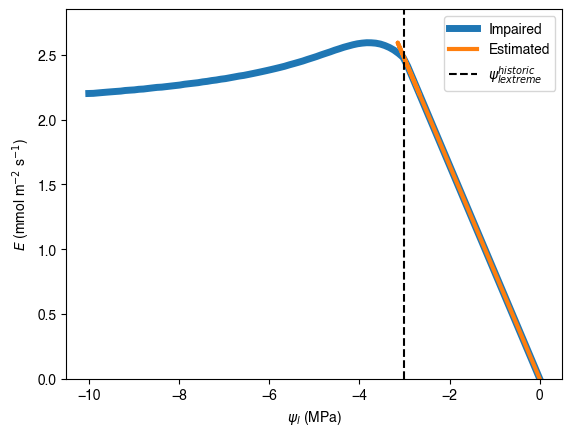

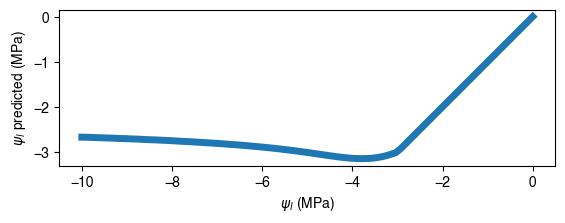

In [16]:
k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

psi_r = -0.0 # MPa
psi_l = np.linspace(psi_r, -10.0, 100) # MPa
psi_r_extreme = -1.0 # MPa
psi_l_extreme = -3.0 # MPa

E_impaired = np.zeros(len(psi_l))
psi_l_est  = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    E_impaired[i], __, __ = impaired_transpiration_CW(psi_r, psi_l[i], psi_r_extreme, psi_l_extreme, k_max, b, c)
    psi_l_est[i] = psi_l_case_1_CW(psi_r, psi_l_extreme, psi_r_extreme, E_impaired[i], k_max, b, c)
    
# -- Plotting --
plt.plot(psi_l, E_impaired, label = 'Impaired', linewidth = 5)
plt.plot(psi_l_est, E_impaired, label = 'Estimated', linewidth = 3)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.ylim(0, 1.1*max(E_impaired))
plt.legend()
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$E$ (mmol m$^{-2}$ s$^{-1}$)")
plt.show()

plt.plot(psi_l, psi_l_est, linewidth = 5)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.gca().set_aspect('equal')
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$\psi_l$ predicted (MPa)")
plt.show()

#### SOX

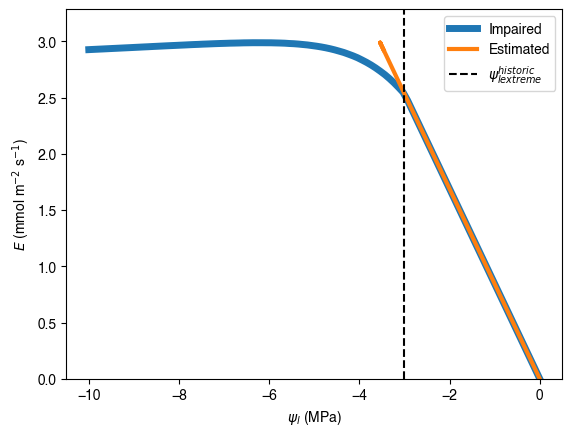

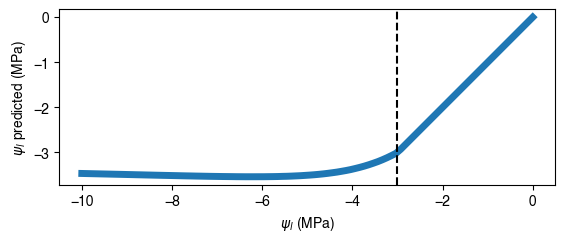

In [17]:
k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

psi_r = -0.0 # MPa
psi_l = np.linspace(psi_r, -10.0, 100) # MPa
psi_r_extreme = -1.0 # MPa
psi_l_extreme = -3.0 # MPa

E_impaired = np.zeros(len(psi_l))
psi_l_est  = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    E_impaired[i], __, __ = impaired_transpiration_SOX(psi_r, psi_l[i], psi_r_extreme, psi_l_extreme, k_max, b, c)
    psi_l_est[i] = psi_l_case_1_SOX(psi_r, psi_l_extreme, psi_r_extreme, E_impaired[i], k_max, b, c)
    
# -- Plotting --
plt.plot(psi_l, E_impaired, label = 'Impaired', linewidth = 5)
plt.plot(psi_l_est, E_impaired, label = 'Estimated', linewidth = 3)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.ylim(0, 1.1*max(E_impaired))
plt.legend()
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$E$ (mmol m$^{-2}$ s$^{-1}$)")
plt.show()

plt.plot(psi_l, psi_l_est, linewidth = 5)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.gca().set_aspect('equal')
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$\psi_l$ predicted (MPa)")
plt.show()

For both the Cumulative Weibull and SOX vulnerability curves we can see that the code above easily solves the case when $\psi_l > \psi_{l\text{extreme}}^{historic}$. 

# Case 2: $\psi_{l\text{extreme}} = \psi_l$

This case is more difficult as the leaf water potential appears in both the numerator and the denominator of the scaling factor and the upper limit of the integral. To solve this we will use a Newton-Raphson approximation. The equation for the updated leaf water potential is;

$$
\psi_{l,n+1} = \psi_{l,n} - \frac{E(\psi_{l,n}) - E_{\text{obs}}}{\frac{dE}{d\psi_l}|_{\psi_{l,n}}}
$$

Where $E_{\text{obs}}$ is the observed transpiration rate and $\frac{dE}{d\psi_l}$ is the derivative of the transpiration rate with respect to the leaf water potential. The derivative of the transpiration rate is given by;

$$
\frac{dE}{d\psi_l} = \frac{\psi_r - \psi_{r\text{extreme}}}{(\psi_l - \psi_r)(\psi_l - \psi_{r\text{extreme}})} E(\psi_l) + \frac{\psi_l - \psi_r}{\psi_l - \psi_{r\text{extreme}}}k(\psi_l)
$$

## Derivative calculation
Let's start by writing code to calculate the derivative of the transpiration for the two vulnerability curves.

In [18]:
def dEdpsi_CW(psi_r, psi_l, k_max, b, c, psi_r_extreme, N = 1000, precision = 0.001):
    """
    Calculates the derivative of the transpiration rate with respect to the leaf water potential
    for the Cumulative Weibull distribution.
    """
    
    # Calculate the transpiration and conductance
    E, __, __ = impaired_transpiration_CW(psi_r, psi_l, psi_r_extreme, psi_l, k_max, b, c, N, precision)
    k = conductance_CW(psi_l, b, c)
    
    # Calculate the derivative using the two components
    A = - (psi_r - psi_r_extreme) / ((psi_l - psi_r)*(psi_l - psi_r_extreme) + 1e-10) * E
    B = (psi_l - psi_r) / (psi_l - psi_r_extreme + 1e-10) * k
    
    return A + B, A, B

def dEdpsi_SOX(psi_r, psi_l, k_max, b, c, psi_r_extreme, N = 1000, precision = 0.001):
    """
    Calculates the derivative of the transpiration rate with respect to the leaf water potential
    for the SOX distribution.
    """
    
    # Calculate the transpiration and conductance
    E, __, __ = impaired_transpiration_SOX(psi_r, psi_l, psi_r_extreme, psi_l, k_max, b, c, N, precision)
    k = conductance_SOX(psi_l, b, c)
    
    # Calculate the derivative using the two components
    A = - (psi_r - psi_r_extreme) / ((psi_l - psi_r)*(psi_l - psi_r_extreme) + 1e-10) * E
    B = (psi_l - psi_r) / (psi_l - psi_r_extreme + 1e-10) * k
    
    return A + B, A, B

### Visualisation
Lets quickly visulise the transpiration derivatives for the two separate vulnerability curves.
#### Cumulative Weibull

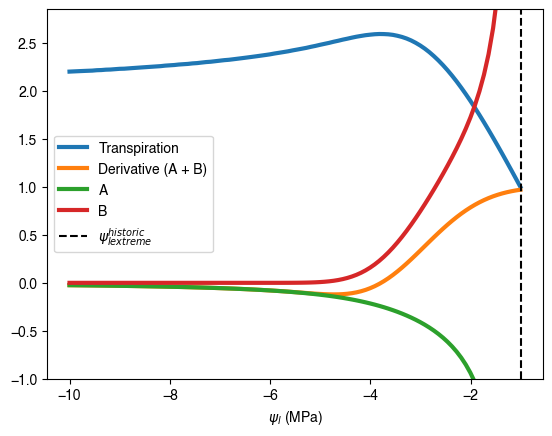

In [19]:
k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

psi_r = -0.0 # MPa# MPa
psi_r_extreme = -1.0 # MPa
psi_l_extreme = -1.0 # MPa

psi_l = np.linspace(psi_r_extreme - 0.01, -10.0, 100) 

E_impaired = np.zeros(len(psi_l))
E_derivative = np.zeros(len(psi_l))
A = np.zeros(len(psi_l))
B = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    E_impaired[i], __, __ = impaired_transpiration_CW(psi_r, psi_l[i], psi_r_extreme, psi_l_extreme, k_max, b, c)
    E_derivative[i], A[i], B[i] = dEdpsi_CW(psi_r, psi_l[i], k_max, b, c, psi_r_extreme)
    
# -- Plotting --
plt.plot(psi_l, E_impaired, label = 'Transpiration', linewidth = 3)
plt.plot(psi_l, E_derivative, label = 'Derivative (A + B)', linewidth = 3)
plt.plot(psi_l, A, label = 'A', linewidth = 3)
plt.plot(psi_l, B, label = 'B', linewidth = 3)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.ylim(-1., 1.1*max(E_impaired))
plt.legend()
plt.xlabel("$\psi_l$ (MPa)")
#plt.ylabel("$\frac{dE}{d\psi_l}$")
plt.show()

We can see that there is an infinite gradient when $\psi_l$, and hence $\psi_{l \text{extreme}}$, is equal to $\psi_{r \text{extreme}}$. This results in divisions by zero. Note that phisicaly $\psi_{l \text{extreme}}$ being equal to $\psi_{r \text{extreme}}$ implies a past extreme root water potential event with fully closed sotmata (no transpiration) and that since that event the leaf water potential has not reached a new extreme. 

This infinity is not a problem that we need to worry about as the solution for the previous case (case 1) applies to the point $\psi_l = \psi_{l \text{extreme}}$

#### SOX

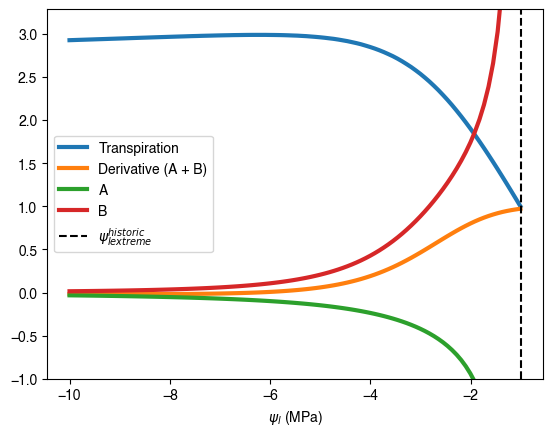

In [20]:
k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

psi_r = -0.0 # MPa# MPa
psi_r_extreme = -1.0 # MPa
psi_l_extreme = -1.0 # MPa

psi_l = np.linspace(psi_r_extreme - 0.01, -10.0, 100) 

E_impaired = np.zeros(len(psi_l))
E_derivative = np.zeros(len(psi_l))
A = np.zeros(len(psi_l))
B = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    E_impaired[i], __, __ = impaired_transpiration_SOX(psi_r, psi_l[i], psi_r_extreme, psi_l_extreme, k_max, b, c)
    E_derivative[i], A[i], B[i] = dEdpsi_SOX(psi_r, psi_l[i], k_max, b, c, psi_r_extreme)
     
# -- Plotting --
plt.plot(psi_l, E_impaired, label = 'Transpiration', linewidth = 3)
plt.plot(psi_l, E_derivative, label = 'Derivative (A + B)', linewidth = 3)
plt.plot(psi_l, A, label = 'A', linewidth = 3)
plt.plot(psi_l, B, label = 'B', linewidth = 3)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.ylim(-1., 1.1*max(E_impaired))
plt.legend()
plt.xlabel("$\psi_l$ (MPa)")
#plt.ylabel("$\frac{dE}{d\psi_l}$")
plt.show()

## Newton-Raphson approximation

Now we have code to calculate the derivatives of the transpiration we can impliment the Newton-Raphson approximation to solve for the leaf water potential when $\psi_l = \psi_{l \text{extreme}}$.

In [21]:
def NR(E_obs, psi_r, psi_l_init, E_func, derivative_func, k_max, b, c, Itters = 100, Precision = 0.01, verbose = False, itters_out = False):

    """
    Use the Newton-Raphson aproximation to estimate the leaf water potential for
    a given transpiration rate.
    """
    
    psi_l = psi_l_init
    
    for i in range(Itters):

        E_current = E_func(psi_l)
        k_current = -derivative_func(psi_l)

        psi_l_new = psi_l - (E_current - E_obs)/k_current
        
        if( verbose ):
            print("\nitter    = ", i)
            print("psi_l     = ", psi_l)
            print("E_current = ", E_current)
            print("E_obs     = ", E_obs)
            print("k_current = ", k_current)
        
        if(np.abs(E_current - E_obs) < Precision):
            psi_l = psi_l_new
            break

        psi_l = psi_l_new

    if(itters_out):
        return psi_l, i
    return psi_l

def psi_l_case_2_CW(psi_r, psi_l_extreme, psi_r_extreme, E, k_max, b, c, psi_l_init = 0.0,  N = 1000, precision = 0.001, verbose = False):
    """
    Solve for the leaf water potential for a Cumulative Weibull vulnerability curve when the leaf water potential is equal to the historic minimum.
    """
    
    # Update the extreme root water potential if needed
    psi_r_extreme = min(psi_r, psi_r_extreme)
    
    # Define the functions
    E_func = lambda psi_l: impaired_transpiration_CW(psi_r, psi_l, psi_r_extreme, psi_l, k_max, b, c)[0]
    dE_func = lambda psi_l: dEdpsi_CW(psi_r, psi_l, k_max, b, c, psi_r_extreme)[0]
    
    # Solve for the leaf water potential
    return NR(E, psi_r, psi_l_init, E_func, dE_func, k_max, b, c, verbose = verbose)

def psi_l_case_2_SOX(psi_r, psi_l_extreme, psi_r_extreme, E, k_max, b, c, psi_l_init = 0.0, N = 1000, precision = 0.001, verbose = False):
    """
    Solve for the leaf water potential for a Cumulative Weibull vulnerability curve when the leaf water potential is equal to the historic minimum.
    """
    
    # Update the extreme root water potential if needed
    psi_r_extreme = min(psi_r, psi_r_extreme)
    
    # Define the functions
    E_func = lambda psi_l: impaired_transpiration_SOX(psi_r, psi_l, psi_r_extreme, psi_l, k_max, b, c)[0]
    dE_func = lambda psi_l: dEdpsi_SOX(psi_r, psi_l, k_max, b, c, psi_r_extreme)[0]
    
    # Solve for the leaf water potential
    return NR(E, psi_r, psi_l_init, E_func, dE_func, k_max, b, c, verbose = verbose)

### Visualisation

Let's compare the true relation between leaf water potential and transpiration with that estimated using the above functions.

#### Cumulative Weibull

/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_38979/3745214807.py:8: RuntimeWarning: invalid value encountered in power
  x_l = np.power(psi_l/b,c)
/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_38979/3911388999.py:2: RuntimeWarning: invalid value encountered in scalar power
  return np.exp(-((psi/b)**c))


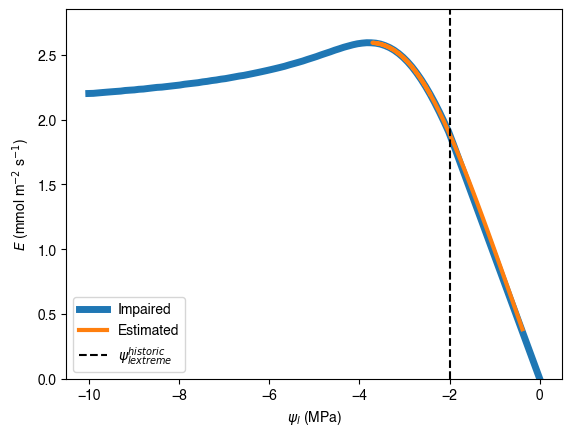

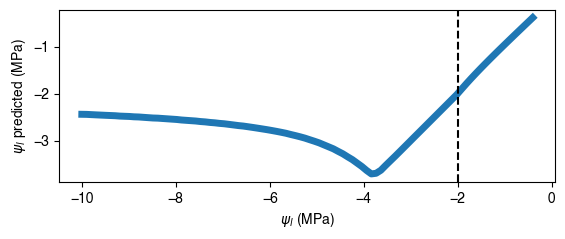

In [22]:
k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

psi_r = -0.0 # MPa
psi_l = np.linspace(psi_r, -10.0, 100) # MPa
psi_r_extreme = -1.0 # MPa
psi_l_extreme = -2.0 # MPa

E_impaired = np.zeros(len(psi_l))
psi_l_est  = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    E_impaired[i], __, __ = impaired_transpiration_CW(psi_r, psi_l[i], psi_r_extreme, psi_l_extreme, k_max, b, c)
    psi_l_est[i] = psi_l_case_2_CW(psi_r, psi_l_extreme, psi_r_extreme, E_impaired[i], k_max, b, c, psi_l_init = psi_l_extreme, verbose = False)
    
# -- Plotting --
plt.plot(psi_l, E_impaired, label = 'Impaired', linewidth = 5)
plt.plot(psi_l_est, E_impaired, label = 'Estimated', linewidth = 3)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.ylim(0, 1.1*max(E_impaired))
plt.legend()
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$E$ (mmol m$^{-2}$ s$^{-1}$)")
plt.show()

plt.plot(psi_l, psi_l_est, linewidth = 5)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.gca().set_aspect('equal')
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$\psi_l$ predicted (MPa)")
plt.show()

#### SOX

/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_38979/1943070235.py:10: RuntimeWarning: invalid value encountered in scalar power
  x_l = -(psi_l/b)**c
/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_38979/235794799.py:2: RuntimeWarning: invalid value encountered in scalar power
  return 1/(1 + (psi/b)**c)


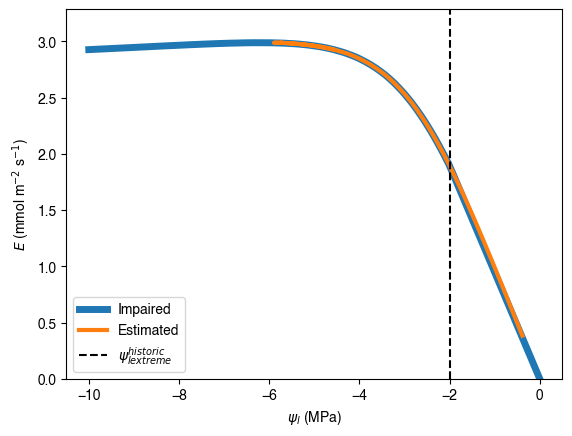

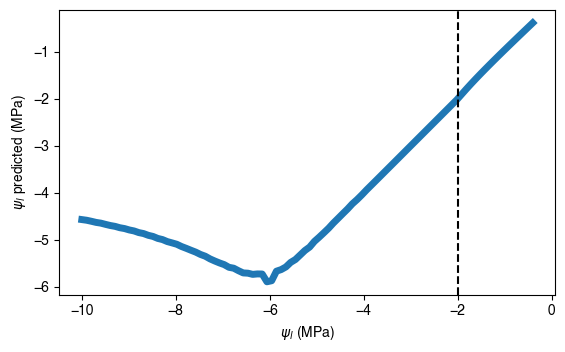

In [23]:
k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

psi_r = -0.0 # MPa
psi_l = np.linspace(psi_r, -10.0, 100) # MPa
psi_r_extreme = -1.0 # MPa
psi_l_extreme = -2.0 # MPa

E_impaired = np.zeros(len(psi_l))
psi_l_est  = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    E_impaired[i], __, __ = impaired_transpiration_SOX(psi_r, psi_l[i], psi_r_extreme, psi_l_extreme, k_max, b, c)
    psi_l_est[i] = psi_l_case_2_SOX(psi_r, psi_l_extreme, psi_r_extreme, E_impaired[i], k_max, b, c, psi_l_init = psi_l_extreme, verbose = False)
    
# -- Plotting --
plt.plot(psi_l, E_impaired, label = 'Impaired', linewidth = 5)
plt.plot(psi_l_est, E_impaired, label = 'Estimated', linewidth = 3)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.ylim(0, 1.1*max(E_impaired))
plt.legend()
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$E$ (mmol m$^{-2}$ s$^{-1}$)")
plt.show()

plt.plot(psi_l, psi_l_est, linewidth = 5)
plt.axvline(psi_l_extreme, label = '$\psi_{l extreme}^{historic}$', color = 'black', linestyle = '--')

# - format figure -
plt.gca().set_aspect('equal')
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("$\psi_l$ predicted (MPa)")
plt.show()